In [482]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from yahoo_fin.stock_info import get_earnings_history
from fredapi import Fred
from dotenv import load_dotenv
import os
import pandas_datareader as web
import lightgbm as lgb
import shap
from datetime import datetime,timedelta


In [421]:

#From yahoo
sp_500 = yf.download(tickers="^GSPC",start="1995-01-01",interval="1d")
#Download data from FRED API
load_dotenv() #Create environment variable
API_KEY = os.getenv("API_KEY") #Get API_KEY from .env file
fred = Fred(api_key = API_KEY) 
ig_spread = fred.get_series('BAMLC0A0CM',observation_start='1/1/1995') #Investment grade vs treasury
hy_spread = fred.get_series('BAMLH0A0HYM2',observation_start='1/1/1995') #High yield vs treasury
wti = fred.get_series('DCOILWTICO',observation_start='1/1/1995') #WTI - Cushing
treas_3m = fred.get_series('DTB3',observation_start='1/1/1995') #3m treasury bill
treas_5y = fred.get_series('DGS5',observation_start='1/1/1995') #5y treasury bond
treas_10y = fred.get_series('DGS10',observation_start='1/1/1995') #10y treasury bond
treas_30y = fred.get_series('DGS30',observation_start='1/1/1995') #30y treasury bond
binf_5y = fred.get_series('T5YIE',observation_start='1/1/1995') #5y break even inflation
binf_10y = fred.get_series('T10YIE',observation_start='1/1/1995') #10y break even inflation
y10_y2 = fred.get_series('T10Y2Y',observation_start='1/1/1995') #2s10s
y10_m3 = fred.get_series('T10Y3M',observation_start='1/1/1995') #3m10s
vix = fred.get_series('VIXCLS',observation_start='1/1/1995') #vix
eur = fred.get_series('DEXUSEU',observation_start='1/1/1995') #uerusd
jpy = fred.get_series('DEXJPUS',observation_start='1/1/1995') #jpy
gbp = fred.get_series('DEXUSUK',observation_start='1/1/1995') #gbp
cny = fred.get_series('DEXCHUS', observation_start='1/1/1995') #cny





[*********************100%***********************]  1 of 1 completed


In [422]:
#Function for checking if there are NaNs
#If there are then fill the NaNs using linear interpolation
def interpolate_na(data):
    if data.isnull().sum().sum()==0:
        return data
    else:
        return data.interpolate(limit_direction='both')

In [423]:
#Create return variable - target
sp_data = interpolate_na(sp_500['Adj Close']) #Check for NA and interpolate if any found
sp_return = sp_data.pct_change()
sp_return5 = sp_data.pct_change(periods=5) #5days ahead
sp_return10 = sp_data.pct_change(periods=10) #10 days ahead
sp_return15 = sp_data.pct_change(periods=15) #15 days ahead

In [424]:
sp_return5

Date
1995-01-03         NaN
1995-01-04         NaN
1995-01-05         NaN
1995-01-06         NaN
1995-01-09         NaN
                ...   
2023-02-02    0.029388
2023-02-03    0.016194
2023-02-06    0.023224
2023-02-07    0.021439
2023-02-08   -0.000328
Name: Adj Close, Length: 7076, dtype: float64

In [ ]:
""" Features:
1. S&P 500 returns variance - 5 day,10 day and 21 day
2. IG and HY spread
3. Change in IG and HY spread in bps
4. Change in crude oil prices
5. 3m,5y,10y and 30y yields
6. Change in 3m,5y,10y,30y in bps
7. 5y and 10y breakeven inflation
8. Change in 5y,10y breakeven in bps
9. 2s10s,3m10s
10. Change in 2s10s,3m10s
11. VIX and change in VIX
12. Change in currencies
"""

In [425]:
#Rolling-window variance S&P 500 returns
sp_var5 = sp_return.rolling(5).var()
sp_var10 = sp_return.rolling(10).var()
sp_var21 = sp_return.rolling(21).var()

In [426]:
#Corporate spreads
ig_spread = interpolate_na(ig_spread)
hy_spread = interpolate_na(hy_spread)
#Change in spreads
ig_change = ig_spread.diff()*100
hy_change = hy_spread.diff()*100

In [427]:
#Change in wti
wti = interpolate_na(wti)
wti_change = wti.pct_change()

In [428]:
#Yields
treas_3m = interpolate_na(treas_3m)
treas_5y = interpolate_na(treas_5y)
treas_10y = interpolate_na(treas_10y)
treas_30y = interpolate_na(treas_30y)
#Change in yields
treas3m_change = treas_3m.diff()*100 #Change in bps
treas5y_change = treas_5y.diff()*100
treas10y_change = treas_10y.diff()*100
treas30y_change = treas_30y.diff()*100


In [429]:
#Breakeven yields
binf_5y = interpolate_na(binf_5y)
binf_10y = interpolate_na(binf_10y)
#Change in breakeven yields
binf5_change = binf_5y.diff()*100
binf10_change = binf_10y.diff()*100

In [430]:
#2s10s and 3m10s
y10_y2 = interpolate_na(y10_y2)
y10_m3 = interpolate_na(y10_m3)
#Change
y10_y2change = y10_y2.diff()*100
y10_m3change = y10_m3.diff()*100

In [431]:
# VIX and change
vix = interpolate_na(vix)
vix_change = vix.pct_change()

In [432]:
#ccy returns
eur = interpolate_na(eur)
jpy = interpolate_na(jpy)
gbp = interpolate_na(gbp)
cny = interpolate_na(cny)
#ccy change
eur_change = eur.pct_change()
jpy_change = jpy.pct_change()
gbp_change = gbp.pct_change()
cny_change = cny.pct_change()


In [433]:
#Remove NaNs
sp_return5 = sp_return5.dropna()
sp_return10 = sp_return10.dropna()
sp_return15 = sp_return15.dropna()

In [434]:
np.percentile(sp_return5,5)

-0.038807517503913036

In [350]:
#Let's check their distribution
#N E E D   A   P L O T


0.05   -0.063382
0.10   -0.042189
0.15   -0.030648
0.20   -0.020853
0.25   -0.013444
0.50    0.009856
0.90    0.046676
Name: Adj Close, dtype: float64

In [435]:
#Make binary target series

sp_binary1 = np.where(sp_return5<np.percentile(sp_return5,5),1,0) #returns in next 5 days less than bottom 5%
sp_binary2 = np.where(sp_return5<np.percentile(sp_return5,10),1,0) #returns in next 5 days less than bottom 10%
sp_binary3 = np.where(sp_return5<np.percentile(sp_return5,15),1,0) #returns in next 5 days less than bottom 15%
sp_binary4 = np.where(sp_return5<np.percentile(sp_return5,20),1,0) #returns in next 5 days less than bottom 20%
sp_binary5 = np.where(sp_return5<np.percentile(sp_return5,25),1,0) #returns in next 5 days less than bottom 25%


sp_binary6 = np.where(sp_return10<np.percentile(sp_return10,5),1,0) #returns in next 10 days less than historical 5 percentile
sp_binary7 = np.where(sp_return10<np.percentile(sp_return10,10),1,0) #returns in next 10 days less than bottom 10%
sp_binary8 = np.where(sp_return10<np.percentile(sp_return10,15),1,0) #returns in next 10 days less than bottom 15%
sp_binary9 = np.where(sp_return10<np.percentile(sp_return10,20),1,0) #returns in next 10 days less than bottom 20%
sp_binary10= np.where(sp_return10<np.percentile(sp_return10,25),1,0) #returns in next 10 days less than bottom 25%


sp_binary11 = np.where(sp_return15<np.percentile(sp_return15,5),1,0) #returns in next 15 days less than historical 5 percentile
sp_binary12 = np.where(sp_return15<np.percentile(sp_return15,10),1,0) #returns in next 15 days less than bottom 10%
sp_binary13 = np.where(sp_return15<np.percentile(sp_return15,15),1,0) #returns in next 15 days less than bottom 15%
sp_binary14 = np.where(sp_return15<np.percentile(sp_return15,20),1,0) #returns in next 15 days less than bottom 20%
sp_binary15= np.where(sp_return15<np.percentile(sp_return15,25),1,0) #returns in next 15 days less than bottom 25%

In [436]:
#Full dataset
data_0 = pd.concat([sp_var5,sp_var10,sp_var21,ig_spread,ig_change,hy_spread,hy_change,wti_change,treas3m_change,treas5y_change,treas10y_change,treas30y_change,binf5_change,binf10_change,y10_y2,y10_m3,y10_m3change,y10_y2change,vix_change,eur_change,jpy_change,gbp_change,cny_change],axis=1)
data_0 = interpolate_na(data_0)
num_data,num_feature = data_0.shape
feature_num = [f'f_{col}' for col in range(num_feature)]
data_0.columns = feature_num
data_0 = data_0.drop(index=data_0.index[0],axis=0) #Dropping first row 


In [437]:
#Create feature list
f_names = ['sp_var5','sp_var10','sp_var21','ig_spread','ig_change','hy_spread','hy_change','wti_change','treas3m_change','treas5y_change','treas10y_change','treas30y_change','binf5_change','binf10_change','y10_y2','y10_m3','y10_m3change','y10_y2change','vix_change','eur_change','jpy_change','gbp_change','cny_change']
features_names = pd.DataFrame(f_names,feature_num)
features_names

,0
f_0,sp_var5
f_1,sp_var10
f_2,sp_var21
f_3,ig_spread
f_4,ig_change
f_5,hy_spread
f_6,hy_change
f_7,wti_change
f_8,treas3m_change
f_9,treas5y_change


In [ ]:
########################################################## Split data ##############################################################################
# Split data into training, validation and test set
def data_split_size(data, train_share):
    train_size = int(len(data)*train_share)
    valid_size = int((len(data)-train_size)/2)
    test_size = valid_size
    return train_size,valid_size,test_size
def data_split(x_data,y_data,train_size,valid_size,test_size):
    x_train = x_data.iloc[:train_size,:]
    y_train = y_data.iloc[:train_size,:]
    x_valid = x_data.iloc[train_size:train_size+valid_size,:]
    y_valid = y_data.iloc[train_size:train_size+valid_size,:]
    x_test = x_data.iloc[-test_size:,:]
    y_test = y_data.iloc[-test_size:,:]
    return x_train,y_train,x_valid,y_valid,x_test,y_test

In [ ]:
########################################################## Light GBM ###############################################################################

In [ ]:
#First rounds
def train_first_rounds(params,lgb_train,num_boost,valid_set,feature_num,x_train,y_train_target):
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=num_boost,
                valid_sets=valid_set,
                feature_name=feature_num,
                ) 
    #ROC AUC for the training model
    y_pred_train = gbm.predict(x_train)
    auc_train_model = roc_auc_score(y_train_target,y_pred_train)
    print(f"The ROC AUC of trained model's prediction is: {auc_train_model}")
    return gbm,y_pred_train,auc_train_model

#Train next rounds with learning decay
def train_second_rounds(params,lgb_train,num_boost,prev_train,valid_set,feature_num,x_train,y_train_target,learning_param):
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=prev_train,
                valid_sets=valid_set,
                feature_name=feature_num,
                callbacks = [lgb.reset_parameter(learning_rate=lambda iter:learning_param*(0.99 ** iter))]
                )
    #ROC AUC for the training model
    y_pred_train = gbm.predict(x_train)
    auc_train_model = roc_auc_score(y_train_target,y_pred_train)
    print(f"The ROC AUC of trained model's prediction is (10-20 rounds): {auc_train_model}")
    return gbm,y_pred_train,auc_train_model


#Train next rounds with early stopping call back
def train_third_rounds(params,lgb_train,num_boost,prev_model,valid_set,feature_num,stopping_rounds,x_train,y_train_target):
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=num_boost,
                init_model=prev_model,
                valid_sets=valid_set,
                feature_name=feature_num,
                callbacks = [lgb.early_stopping(stopping_rounds=stopping_rounds)])
    #ROC AUC for the training model
    y_pred_train = gbm.predict(x_train)
    auc_train_model = roc_auc_score(y_train_target,y_pred_train)
    print(f"The ROC AUC of trained model's prediction is (20-30 rounds): {auc_train_model}")
    return gbm,y_pred_train,auc_train_model

#Validate
def validate(saved_model,x_valid,y_valid_target):
    #load model to predict on validation data
    bst = lgb.Booster(model_file=saved_model)
    y_pred_valid = bst.predict(x_valid)
    #evaluate on validation data
    auc_loaded_model = roc_auc_score(y_valid_target,y_pred_valid)
    print(f"The ROC AUC of loaded model's prediction is: {auc_loaded_model}")
    return bst,y_pred_valid,auc_loaded_model

#Validate with best iteration
def validate_best(saved_model,x_valid,y_valid_target):
    #load model to predict on validation data
    bst = lgb.Booster(model_file=saved_model)
    y_pred_valid = bst.predict(x_valid,num_iteration=gbm.best_iteration)
    #evaluate on validation data
    auc_loaded_model = roc_auc_score(y_valid_target,y_pred_valid)
    print(f"The ROC AUC of loaded model's prediction is:(20-30 rounds) {auc_loaded_model}")
    return bst,y_pred_valid,auc_loaded_model


In [ ]:
############################################################# 5 -day ahead model ########################################################################

In [581]:
#5-day ahead target series
y_5d = pd.DataFrame([sp_binary1,sp_binary2,sp_binary3,sp_binary4,sp_binary5]).T
y_5d.index = sp_return5.index
y_5d.columns = ['sp_binary1','sp_binary2','sp_binary3','sp_binary4','sp_binary5']
f_horizon = 5
y_5d = y_5d.shift(-f_horizon) #5-day ahead return
y_5d = y_5d.iloc[:-f_horizon,:] #Last 5 rows dropped
#5-day ahead data
data_5d = data_0.iloc[:-f_horizon,:] #Last 5 rows dropped
#Merge date indices
common_idx = y_5d.index.intersection(data_5d.index)
data_5d = data_5d.loc[common_idx]
#Split data
train_size,valid_size,test_size = data_split_size(data_5d,0.75)
x_train,y_train,x_valid,y_valid,x_test,y_test = data_split(data_5d,y_5d,train_size,valid_size,test_size)




In [577]:
#config
params = {
    'bossting_type': 'gbdt',
    'ojective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves':16, 
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction':0.8,
    'bagging_freq':5,
    'verbose': 0

}
###### 5-day ahead model 1 ######

#create a dataset for lightgbm
lgb_train = lgb.Dataset(x_train,y_train['sp_binary1'],free_raw_data=False)
lgb_eval = lgb.Dataset(x_valid,y_valid['sp_binary1'],reference=lgb_train,free_raw_data=False)
y_train_target = y_train['sp_binary1']
y_valid_target = y_valid['sp_binary1']
valid_set = lgb_train
num_boost=10

######Start training first 10 rounds ######

gbm,y_pred_train,auc_train_model = train_first_rounds(params,lgb_train,num_boost,valid_set,feature_num,x_train,y_train_target)
gbm.save_model('model_5d1.txt')
saved_model = 'model_5d1.txt'

######Validate ######

bst,y_pred_valid,auc_loaded_model = validate(saved_model,x_valid)

######Start training next 10 rounds ######

gbm,y_pred_train,auc_train_model = train_second_rounds(params,lgb_train,num_boost,prev_train,valid_set,feature_num,x_train,y_train_target,learning_param):




In [584]:
####################################################Check against validation set##########################################################

In [586]:


# Based on validation dataset, iterations over bagging_freq and bagging_frac, num_leaves=16 is optimal

In [ ]:
####################################################Training next 10-20 rounds#########################################################

In [448]:
#Continue training with learning decay
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                valid_sets=lgb_eval,
                feature_name=feature_num,
                callbacks = [lgb.reset_parameter(learning_rate=lambda iter:0.05*(0.99 ** iter))])
#ROC AUC for the training model
y_pred_train = gbm.predict(x_train)
auc_train_model = roc_auc_score(y_train['sp_binary1'],y_pred_train)
print(f"The ROC AUC of trained model's prediction is (10-20 rounds): {auc_train_model}")

#Saving model
gbm.save_model('model_5d1_learning_decay.txt')
#load model to predict on validation data
bst = lgb.Booster(model_file='model_5d1_learning_decay.txt')
####################################################Check against validation#########################################################

y_pred_valid = bst.predict(x_valid)
#evaluate on validation data
auc_loaded_model = roc_auc_score(y_valid['sp_binary1'],y_pred_valid)
print(f"The ROC AUC of loaded model's prediction is:(10-20 rounds) {auc_loaded_model}")


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
The ROC AUC of trained model's prediction is (10-20 rounds): 0.8769307145876875
The ROC AUC of loaded model's prediction is:(10-20 rounds) 0.5874870197300104


In [ ]:
####################################################Traing next 20-30 rounds#########################################################

In [450]:
#Continue training with early stopping call back
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                valid_sets=lgb_eval,
                feature_name=feature_num,
                callbacks = [lgb.early_stopping(stopping_rounds=5)])
#ROC AUC for the training model
y_pred_train = gbm.predict(x_train)
auc_train_model = roc_auc_score(y_train['sp_binary1'],y_pred_train)
print(f"The ROC AUC of trained model's prediction is (20-30 rounds): {auc_train_model}")

#Saving model
gbm.save_model('model_5d1_early_stopping.txt')
#load model to predict on validation data
bst = lgb.Booster(model_file='model_5d1_early_stopping.txt')
####################################################Check against validation#########################################################

y_pred_valid = bst.predict(x_valid,num_iteration=gbm.best_iteration)
#evaluate on validation data
auc_loaded_model = roc_auc_score(y_valid['sp_binary1'],y_pred_valid)
print(f"The ROC AUC of loaded model's prediction is:(20-30 rounds) {auc_loaded_model}")

[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	valid_0's bina

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


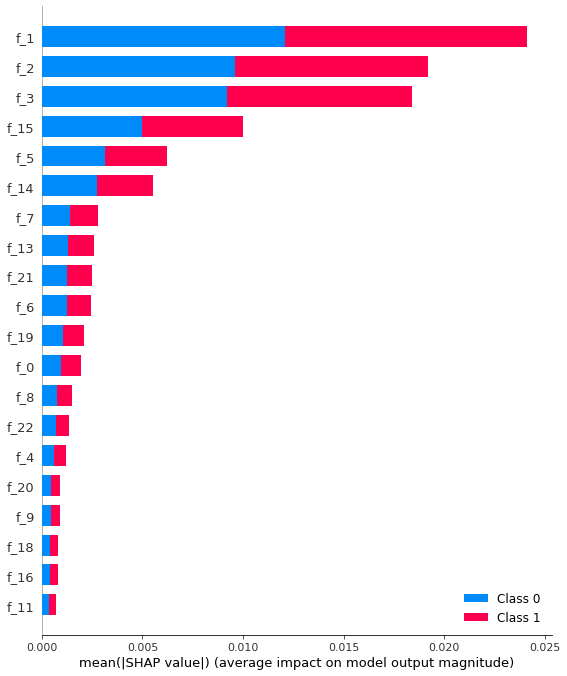

In [451]:
#feature importance
#print(f"Fetaure importances: {list(gbm.feature_importance())}")
#SHAP values
gbm.params['objective'] = 'binary'
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(data_5d)
#print(f"shap values: {shap_values}")
#Average shap values
shap.summary_plot(shap_values,data_5d)

In [ ]:
####################################################Check against test#########################################################

In [452]:
#load model to predict on test data
bst = lgb.Booster(model_file='model_5d1_early_stopping.txt')
# Now we evaluate on the test dataset
y_pred_test = bst.predict(x_test)
#evaluate on validation data
auc_test_model = roc_auc_score(y_test['sp_binary1'],y_pred_test)
print(f"The ROC AUC of test data model's prediction is: {auc_test_model}")

The ROC AUC of test data model's prediction is: 0.6524200081004454


In [ ]:
####################################################Run final model on full dataset#########################################################

In [534]:
#Finally we run the model on the full dataset
bst = lgb.Booster(model_file='model_5d1_early_stopping.txt')
#Now we evaluate on the full sample
y_pred_final = bst.predict(data_5d)
#old_preds
old_preds = pd.DataFrame(y_pred_final,index=data_5d.index)
old_preds

,0
1995-01-03,0.024870
1995-01-04,0.024870
1995-01-05,0.024870
1995-01-06,0.024870
1995-01-09,0.024870
...,...
2023-01-26,0.046039
2023-01-27,0.036338
2023-01-30,0.047668
2023-01-31,0.035063


In [ ]:
####################################################Update model on new data#########################################################

In [469]:
#Fresh data comes in
y_pred_update = bst.predict(data_0)

In [525]:
#Get new dates
new_days = (data_0.index[-1]-data_5d.index[-1]).days
new_dates = []
for x in range(1,new_days+1):
    new_dates.append(data_5d.index[-1]+timedelta(days=x))

new_dates
#New estimates
new_preds = pd.DataFrame(y_pred_update[-new_days:],index=new_dates)
new_preds

,0
2023-02-02,0.035063
2023-02-03,0.034032
2023-02-04,0.032815
2023-02-05,0.043059
2023-02-06,0.033716
2023-02-07,0.032499
2023-02-08,0.033846


Text(0.5, 1.0, 'Probability of return < 5th percentile in next 5 days')

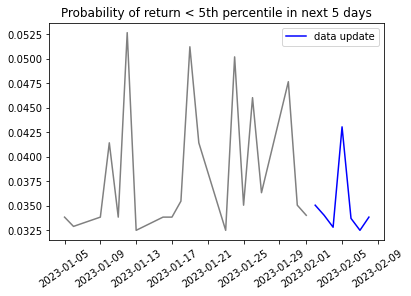

In [544]:
plt.plot(old_preds.iloc[-20:],color='grey')
plt.plot(new_preds,color='blue',label='data update')
plt.legend()
plt.xticks(rotation = 35)
plt.title(f'Probability of return < {f_horizon}th percentile in next 5 days')

Text(0.5, 1.0, 'Probability of return < 5th percentile on out of sample dates')

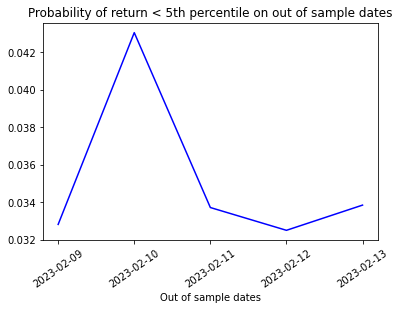

In [573]:
#Out of sample forecasts
oos_dates = []
for x in range(1,f_horizon+1):
    oos_dates.append(data_0.index[-1]+timedelta(days=x))

oos_dates = pd.to_datetime(oos_dates)
oos_dates = oos_dates.strftime('%Y-%m-%d')
oof_update = pd.DataFrame(y_pred_update[-f_horizon:],index=oos_dates)
oof_update.columns = ['p(r < 5th percentile)']
plt.plot(oof_update,color='blue')
plt.xticks(rotation = 35)
plt.xlabel('Out of sample dates')
plt.title(f'Probability of return < {f_horizon}th percentile on out of sample dates')



pandas.core.indexes.datetimes.DatetimeIndex